#**Youtube Comments Analysis**

In this notebook, I will use Spark to analyse a dataset of user comments for youtube videos related to animals or pets, in order to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.


### **<br>Set up the Spark Environment**<br><br>

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://apache.forsale.plus/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!ls
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.7-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!ls

sample_data  spark-2.4.7-bin-hadoop2.7	spark-2.4.7-bin-hadoop2.7.tgz


In [ ]:
spark.version

'2.4.7'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os
os.environ['PYSPARK_PYTHON'] = 'python3'

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = "1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('animal_comments.gz') 

## **<br>1. Data Exploration and Cleaning**

### **1.1 Get spark dataframe and drop missing values**<br><br>

In [ ]:
df = spark.read.csv('animal_comments.gz', inferSchema=True, header=True)
df.show()

+--------------------+------+-------------------------------------+
|        creator_name|userid|                              comment|
+--------------------+------+-------------------------------------+
|        Doug The Pug|  87.0|                 I shared this to ...|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|
|         bulletproof| 530.0|                 stop saying get e...|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|
|              ojatro|1031.0|                 I wanna see what ...|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|
|Hope For Paws - O...|1806.0|                 when I saw the en...|
|Hope For Paws - O...|2036.0|                 Holy crap. That i...|
|          Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
|       Brian Barczyk|2698.0|                 Call the teddy Larry|
|            The Dodo|2702.0|                   😐🤔😓😢😭😭😭😭😟|
|Hope For Paws - O...|2911.0|                 That mother cat l...|
|Hope For

In [ ]:
df.count() 

5820035

In [ ]:
df_clean = df.na.drop(subset=["comment"])
df_clean.count()

5818984

### **<br>1.2 Label the data**

Since this dataset doesn't include labels identifying cat/dog owners vs. other users, I'll first manually label the cat/dog owners using explicit criterions, such as "my dog/cat", etc., so as to prepare for classification.<br><br>

In [ ]:
# label dog and cat owners manually
from pyspark.sql.functions import when
from pyspark.sql.functions import col

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [ ]:
df_clean.show()

+--------------------+------+-------------------------------------+-----+
|        creator_name|userid|                              comment|label|
+--------------------+------+-------------------------------------+-----+
|        Doug The Pug|  87.0|                 I shared this to ...|    0|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|    0|
|         bulletproof| 530.0|                 stop saying get e...|    0|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|    0|
|              ojatro|1031.0|                 I wanna see what ...|    0|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|    0|
|Hope For Paws - O...|1806.0|                 when I saw the en...|    0|
|Hope For Paws - O...|2036.0|                 Holy crap. That i...|    0|
|          Life Story|2637.0|武器はクエストで貰えるんじゃないん...|    0|
|       Brian Barczyk|2698.0|                 Call the teddy Larry|    0|
|            The Dodo|2702.0|                   😐🤔😓😢😭😭😭😭😟|

In [ ]:
df_clean.filter(col('label') == 1).count()

40225

In [ ]:
df_clean.filter(col('label') == 0).count()

5778759

<br>The label data are rather sparse: less than 1% data are cat/dog owners. Therefore, for the train/test splitting I should not split the data directly by a 4:1 ratio, since the training data may not include any cat/dog owners.<br><br>

## **2. Data Transformation**

### **2.1 Use word2vec model to get feature**

To get the features for classification, I'll first use RegexTokenizer to tokenize comments into words by white spaces and punctuations, and use Word2Vec model to transform words into distributed vectors.<br><br>

In [ ]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")
word2Vec = Word2Vec(inputCol="words", outputCol="features", numPartitions=10)

In [ ]:
tokenized = regexTokenizer.transform(df_clean)

In [ ]:
word2vecModel = word2Vec.fit(tokenized)

In [ ]:
dataset = word2vecModel.transform(tokenized)

In [ ]:
dataset.show()

+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
|        creator_name|userid|                              comment|label|               words|            features|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
|        Doug The Pug|  87.0|                 I shared this to ...|    0|[i, shared, this,...|[-0.0592416396195...|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|    0|       [super, cute]|[-0.0693858107551...|
|         bulletproof| 530.0|                 stop saying get e...|    0|[stop, saying, ge...|[-0.0500948655588...|
|       Meu Zoológico| 670.0|                 Tenho uma jiboia ...|    0|[tenho, uma, jibo...|[-0.1176272143299...|
|              ojatro|1031.0|                 I wanna see what ...|    0|[i, wanna, see, w...|[-0.1538532463283...|
|     Tingle Triggers|1212.0|                 Well shit now Im ...|    0|[w

### **<br>2.2 Split training testing data**

As previously mentioned, I'll not split the dataset directly, but split the dataset with all cat/dog owners and the dataset with all other users separately, and then union them into training and testing dataset.<br><br>

In [ ]:
(lable1_train,lable1_test)=dataset.filter(col('label')==1).randomSplit([0.7, 0.3],seed = 100)
(lable0_train, lable0_ex)=dataset.filter(col('label')==0).randomSplit([0.005, 0.995],seed = 100)
(lable0_test, lable1_ex2)=lable0_ex.randomSplit([0.002, 0.998],seed = 100)

In [ ]:
trainingData = lable0_train.union(lable1_train)
testData=lable0_test.union(lable1_test)

In [ ]:
trainingData = trainingData.cache()
testData = testData.cache()

In [ ]:
print("Dataset Count: " + str(dataset.count()))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Dataset Count: 5818984
Training Dataset Count: 57324
Test Dataset Count: 23531


In [ ]:
print("Label 1 Count: ")
print("Training Dataset: " + str(trainingData.filter(col('label') == 1).count()))
print("Test Dataset: " + str(testData.filter(col('label') == 1).count()))

Label 1 Count: 
Training Dataset: 28178
Test Dataset: 12047


In [ ]:
print("Label 0 Count: ")
print("Training Dataset: " + str(trainingData.filter(col('label') == 0).count()))
print("Test Dataset: " + str(testData.filter(col('label') == 0).count()))

Label 0 Count: 
Training Dataset: 29146
Test Dataset: 11484


## **<br>3. Model Building, Training and Evaluation**

For model selection, I'll try three different classifiers: logistic regression, random forest classifier, and gradient boosted trees classifier. For every classifier, I'll first train and evaluate an initial model to get the baseline performance, and then build a 5-fold cross-evaluation model to tune the hyper-parameters using parameter grid and find the best model.<br><br>

### **3.1 Build logistic regression model**

**3.1.1 Build and evaluate an initial LR model**<br><br>

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)

In [ ]:
predictions = lrModel.transform(testData)
predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[7.38441844464278...|[0.99937953359934...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[5.15580096990588...|[0.99426719460822...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[4.09492946800258...|[0.98361598613859...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[-0.7493699753185...|[0.32095859

In [ ]:
lrModel.coefficients

DenseVector([0.9552, -0.1075, 2.3018, -3.5171, 4.5903, -6.5384, 7.2889, 3.0548, -2.926, 4.4528, -6.563, 5.6296, -4.0702, 2.6913, -3.1774, 2.4336, -2.7731, 3.0708, 4.8649, -2.7973, -2.8165, 7.2416, 1.6482, 4.2717, -4.4145, -4.496, 3.2212, 5.5335, -7.5836, -3.774, 7.9775, 6.9195, 0.2822, 6.8689, -2.4032, 1.5928, -1.2289, -0.3882, 2.793, -3.7013, -3.663, 0.3213, -2.7048, -5.2256, 0.5657, -3.7991, -1.0758, 0.1321, 1.6281, -1.3595, -0.234, -4.5776, 2.5944, 3.8001, -0.6366, 4.1605, -4.6877, 4.2165, -1.1052, -0.0912, 5.6022, -2.3918, 0.7603, 2.5646, -3.0246, 1.7224, 1.9938, -2.8401, 6.2146, -7.4925, -6.5074, 1.9403, -1.6801, -6.0513, 8.5908, 1.8044, -2.7063, -1.0907, -0.2914, -5.1881, 0.79, -3.693, -4.8398, -3.7377, 4.7908, -0.245, -7.7795, 2.1381, -0.7948, -4.7391, -6.857, 2.7838, -6.3712, 0.6656, -2.9488, -2.496, -2.0075, -5.8965, -1.8902, 5.631])

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator # metric: area under ROC

# Evaluate initial model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.9551466641870903

**<br>3.1.2 Build a cross-validation model and tune hyperparameters**<br><br>

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.01, 1, 5, 10])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20])
             .build())

In [ ]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)

In [ ]:
cv_predictions = cvModel.transform(testData)
cv_predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[6.59673747596852...|[0.99863704665838...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[4.85515959441611...|[0.99227209530136...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[3.48376377056917...|[0.97022225207852...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[-1.3217798315453...|[0.21052232

In [ ]:
area_under_roc = evaluator.evaluate(cv_predictions)

In [ ]:
accuracy = cv_predictions.filter(col('label')==col('prediction')).count()/cv_predictions.count()

In [ ]:
bestModel = cvModel.bestModel

In [ ]:
bestModel.coefficients

DenseVector([-1.3479, -1.3667, 0.3811, -3.688, 2.8107, -5.8493, 4.5848, 2.6023, -2.8941, 4.7755, -7.0059, 4.8859, -5.2408, 2.1127, -2.5682, 2.8251, -5.1032, 2.0021, 5.7941, -2.5361, -2.9226, 6.9883, 1.7731, 2.2277, -4.1499, -4.1874, 0.3726, 3.7391, -6.2234, -4.1053, 6.9704, 5.279, -1.0014, 6.028, -1.2007, 0.8649, -0.2546, -0.1027, 1.8787, -2.1452, -3.5057, 1.4449, -2.9878, -5.7037, 2.257, -5.3013, -2.2764, -0.4986, 3.3596, -3.302, -1.9306, -4.3285, 1.5488, 3.2232, 0.915, 4.6957, -3.6769, 2.3433, -1.5759, 0.7596, 4.896, -2.2635, -0.1041, 3.2987, -3.2362, 1.8209, 1.5144, -1.475, 5.5471, -7.8385, -5.3483, 0.4951, -1.8647, -3.1386, 9.1547, 0.3117, -6.0649, -0.1988, 1.0914, -6.0131, 0.905, -3.2294, -2.1881, -4.377, 3.9302, 0.0092, -5.4922, 2.3635, -2.6198, -5.0918, -5.527, 1.0424, -5.395, 1.8298, -3.052, -1.8659, -3.1068, -5.2809, -1.3509, 5.6448])

In [ ]:
# Print evaluation metrics and best model parameters
print('Area under ROC = ' + str(area_under_roc))
print('Accuracy = ' + str(accuracy))
print('**Best Model**')
print(' MaxIter: ' + str(bestModel._java_obj.parent().getMaxIter()))
print(' RegParam: ' + str(bestModel._java_obj.parent().getRegParam()))
print(' ElasticNetParam: ' + str(bestModel._java_obj.parent().getElasticNetParam()))

Area under ROC = 0.9570132937761288
Accuracy = 0.9008541923420169
**Best Model**
 MaxIter: 20
 RegParam: 0.001
 ElasticNetParam: 0.0


### **<br>3.2 Build random forest model**

**3.2.1 Build and evaluate an initial RF model**<br><br>

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingData)

In [ ]:
predictions = rfModel.transform(testData)

In [ ]:
predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[17.6811580053921...|[0.88405790026960...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[16.8911131539817...|[0.84455565769908...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[12.6619781489506...|[0.63309890744753...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[13.2951002312078...|[0.66475501

In [ ]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9499768113319492

**<br>3.2.2 Build and tune a CV model**<br><br>

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [3, 5, 7])
             .addGrid(rf.maxBins, [32, 60])
             .addGrid(rf.numTrees, [10, 20])
             .build())

In [ ]:
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trainingData)

In [ ]:
cv_predictions = cvModel.transform(testData)
cv_predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[18.3914373988410...|[0.91957186994205...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[17.5505390427106...|[0.87752695213553...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[14.5358958831694...|[0.72679479415847...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[14.2760268712635...|[0.71380134

In [ ]:
area_under_roc = evaluator.evaluate(cv_predictions)

In [ ]:
accuracy = cv_predictions.filter(col('label')==col('prediction')).count()/cv_predictions.count()

In [ ]:
bestModel = cvModel.bestModel

In [ ]:
# Print evaluation metrics and best model parameters
print('Area under ROC = ' + str(area_under_roc))
print('Accuracy = ' + str(accuracy))
print('**Best Model**')
print(' MaxDepth: ' + str(bestModel._java_obj.parent().getMaxDepth()))
print(' MaxBins: ' + str(bestModel._java_obj.parent().getMaxBins()))
print(' NumTrees: ' + str(bestModel._java_obj.parent().getNumTrees()))

Area under ROC = 0.9576811181631489
Accuracy = 0.8994942841358209
**Best Model**
 MaxDepth: 7
 MaxBins: 32
 NumTrees: 20


### <br>**3.3 Build gradient boosting model**

**3.3.1 Build an initial GBT model**<br><br>

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='features', labelCol='label')
gbtModel = gbt.fit(trainingData)

In [ ]:
predictions = gbtModel.transform(testData)

In [ ]:
predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[1.62630083715347...|[0.96276648770535...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[1.81726164796846...|[0.97428234182790...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[1.22126710958151...|[0.92001377564418...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[1.64253440459006...|[0.96391301

In [ ]:
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.9601373995620903

**<br>3.3.2 Build and tune a CV model**<br><br>

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3, 5, 7])
             .addGrid(gbt.maxBins, [32, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [ ]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5, parallelism=3)
cvModel = cv.fit(trainingData)

In [ ]:
cv_predictions = cvModel.transform(testData)
cv_predictions.show()

+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|creator_name|  userid|             comment|label|               words|            features|       rawPrediction|         probability|prediction|
+------------+--------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        null| 18714.0|Pyara write by freed|    0|[pyara, write, by...|[-0.1094990409910...|[1.63173911455104...|[0.96315442506808...|       0.0|
|        null| 20999.0|@JayPerView Steve...|    0|[jayperview, stev...|[-0.1273555860130...|[1.77861070429507...|[0.97227276942714...|       0.0|
|        null| 24314.0|season 2 is almos...|    0|[season, 2, is, a...|[-0.2163066130808...|[1.58661638574169...|[0.95981446022981...|       0.0|
|        null| 47748.0|Great picks! You ...|    0|[great, picks, yo...|[-0.1148337381226...|[1.31315094910279...|[0.93253526

In [ ]:
area_under_roc = evaluator.evaluate(cv_predictions)

In [ ]:
accuracy = cv_predictions.filter(col('label')==col('prediction')).count()/cv_predictions.count()

In [ ]:
bestModel = cvModel.bestModel

In [ ]:
# Print evaluation metrics and best model parameters
print('Area under ROC = ' + str(area_under_roc))
print('Accuracy = ' + str(accuracy))
print('**Best Model**')
print(' MaxDepth: ' + str(bestModel._java_obj.parent().getMaxDepth()))
print(' MaxBins: ' + str(bestModel._java_obj.parent().getMaxBins()))
print(' MaxIter: ' + str(bestModel._java_obj.parent().getMaxIter()))

Area under ROC = 0.9646332768640975
Accuracy = 0.9012791636564532
**Best Model**
 MaxDepth: 7
 MaxBins: 32
 MaxIter: 20


## <br>**4. Classify All Users Using the Best Model**

I will use the Gradient Boosted Tree model to classify all users who are cat/dog owners since it gives the best Area under ROC score and accuracy.<br><br>

In [ ]:
full_predictions = bestModel.transform(dataset)
full_predictions.show()

+--------------------+------+-------------------------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        creator_name|userid|                              comment|label|               words|            features|       rawPrediction|         probability|prediction|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|        Doug The Pug|  87.0|                 I shared this to ...|    0|[i, shared, this,...|[-0.0592416396195...|[-1.0515766441385...|[0.10879071584078...|       1.0|
|        Doug The Pug|  87.0|                   Super cute  😀🐕🐶|    0|       [super, cute]|[-0.0693858107551...|[1.56984364539198...|[0.95850044373980...|       0.0|
|         bulletproof| 530.0|                 stop saying get e...|    0|[stop, saying, ge...|[-0.0500948655588...|[1.31956013195049...|[0.93333724913765...| 

In [ ]:
evaluator.evaluate(full_predictions)

0.9682779655772468

In [ ]:
fraction = full_predictions.filter(col('prediction')==1).count()/full_predictions.count()
print('Estimated fraction of all users who are cat/dog owners = ' + str(fraction))

Estimated fraction of all users who are cat/dog owners = 0.12318318799295547


## <br>**5. Find Topics Important to Cat/Dog Owners**

Since the features transformed by the Word2vec model are fixed-length vectors, I will use K-means Clustering to cluster the comments of the predicted cat/dog owners, and find the most important words for each cluster using the cosine similarity between words and cluster centroids. This can be implemented by the findSynonym method of the Word2VecModel.<br><br>

In [ ]:
df_clusters = full_predictions.filter(col('prediction')==1).select('features')

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(predictionCol='clusters', k=100, seed=50, distanceMeasure='cosine')
kmeansModel = kmeans.fit(df_clusters)

In [ ]:
clusters_transformed = kmeansModel.transform(df_clusters)
clusters_transformed.show()

+--------------------+--------+
|            features|clusters|
+--------------------+--------+
|[-0.0592416396195...|      62|
|[-0.1538532463283...|       5|
|[-0.0850109684190...|      76|
|[-0.0547502618494...|      86|
|[-0.1267645139755...|      74|
|[0.11997507512569...|       0|
|[-0.1022008544176...|       3|
|[-0.1153158028610...|      13|
|[-0.1294128547112...|      15|
|[-0.0336677059531...|      91|
|[-0.0752921120908...|      42|
|[-0.1431008405273...|      68|
|[-0.0798252732313...|      40|
|[-0.0913082447981...|      24|
|[0.02792414557188...|      55|
|[-0.1344356139500...|      46|
|[-0.1099661831185...|      34|
|[-0.1099661831185...|      34|
|[-0.0500081327045...|      24|
|[-0.2407143215338...|      54|
+--------------------+--------+
only showing top 20 rows



In [ ]:
#evaluate clustering with silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(predictionCol='clusters', distanceMeasure='cosine')
silhouette = evaluator.evaluate(clusters_transformed)
print("Silhouette with cosine similarity = " + str(silhouette))

Silhouette with cosine similarity = 0.021729762635896266


In [ ]:
centers = kmeansModel.clusterCenters()

In [ ]:
#the number of comments within each cluster
clusters_counts = clusters_transformed.groupBy('clusters').count().orderBy('clusters').toPandas()

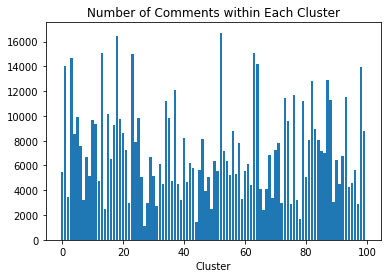

In [ ]:
plt.bar('clusters', 'count', data=clusters_counts)
plt.xlabel('Cluster')
plt.title('Number of Comments within Each Cluster')
plt.show()

In [ ]:
# print out important words of clusters
def important_words(centers, n_words):
  words_array = []
  num_clusters = []

  for i in range(len(centers)):
    df_similarity = word2vecModel.findSynonyms(centers[i], n_words).toPandas()
    if df_similarity.iloc[0, 1] > 0.75: # only select clusters with words having similarity greater than 0.75
      alist = df_similarity['word'].to_numpy()
      alist = np.append(alist, df_similarity.iloc[0,1])
      words_array.append(alist)
      num_clusters.append(i)
  
  df_words = pd.DataFrame(words_array)
  columns = ['Word '+str(i) for i in range(n_words)]
  columns.append('similarity')
  df_words.columns = columns
  df_words.index = ['Cluster '+str(i) for i in num_clusters]
  df_words = df_words.sort_values(by='similarity', ascending=False)
  return df_words.iloc[:, :df_words.shape[1] - 1]

In [ ]:
df_importantwords = important_words(centers, 10)
df_importantwords.head(15)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Cluster 89,dog,puppy,pup,pitty,mutt,husky,rootweiler,poodle,yorkie,cat
Cluster 0,cat,kitten,ginger,tortie,kitty,tabby,tomcat,tortoiseshell,bangle,tuxedo
Cluster 31,my,memy,bettys,dads,fiances,lillo,moms,boyfriends,mums,eldest
Cluster 61,pomeranian,boxer,gsd,rottie,jackrussel,greyhound,samoyed,multipoo,shep,wheaten
Cluster 22,husky,huskey,corgi,huskie,pekingese,pomeranian,samoyed,beagle,dachshund,puppy
Cluster 27,ksksksks,ksksksksks,ksksks,ksksksksksks,kskskskss,ksks,robin,seplut,ksksksksk,purring
Cluster 44,floppycats,gsas,822799633621524480,icanvas,aprilthegiraffe,analytics,github,sendspace,threads,www
Cluster 96,spunky,fluffball,munchkin,puffski,fluffy,sweetly,sassy,graycie,furball,lovey
Cluster 90,57,41,48,53,22,52,21,27,32,44
Cluster 42,alfie,ellie,ziggy,gizmo,olaf,snowball,milly,cleopatra,gizzy,twinkie


<br>As can be seen from the table above, the topics important to cat/dog owners include words such as dog, cat, types of dog, family members, food, etc.<br><br>

Additionally, I'll use K-means clustering on other users that are not predicted as cat/dog owners to find the important words in their comments, and compare the results with that of cat/dog owners. Since the features of other users include some empty vectors transformed from non-English comments which could not be used to compute cosine similarity, I'll first create a udf to exclude those comments.<br><br>

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

def not_empty(x):
  array = x.toArray()
  for i in range(len(array)):
    if array[i] != 0:
      return True
  return False

udf_notEmpty = udf(lambda x: not_empty(x), BooleanType())

non_owners = full_predictions.filter((col('prediction')==0) & (udf_notEmpty('features'))).select('features')
non_owners.show()

+--------------------+
|            features|
+--------------------+
|[-0.0693858107551...|
|[-0.0500948655588...|
|[-0.1176272143299...|
|[-0.0523558720946...|
|[-0.0291302737851...|
|[-0.1600388120859...|
|[-0.1128631052871...|
|[-0.0721068799362...|
|[-0.2025039130821...|
|[-0.0422175992280...|
|[0.02029070574790...|
|[-0.0407281471964...|
|[-0.0786179743635...|
|[-0.2497448652982...|
|[-0.0462199315428...|
|[-0.1356396241113...|
|[-0.1170507422648...|
|[-0.1106693098942...|
|[-0.1016373336315...|
|[-0.2403986334800...|
+--------------------+
only showing top 20 rows



In [ ]:
kmeans2 = KMeans(predictionCol='clusters', k=100, seed=50, distanceMeasure='cosine')
kmeansModel2 = kmeans2.fit(non_owners)

In [ ]:
centers2 = kmeansModel2.clusterCenters()

In [ ]:
transformed = kmeansModel2.transform(non_owners)
transformed.show()

+--------------------+--------+
|            features|clusters|
+--------------------+--------+
|[-0.0693858107551...|      11|
|[-0.0500948655588...|      20|
|[-0.1176272143299...|      91|
|[-0.0523558720946...|      46|
|[-0.0291302737851...|      89|
|[-0.1600388120859...|      22|
|[-0.1128631052871...|      58|
|[-0.0721068799362...|      58|
|[-0.2025039130821...|      24|
|[-0.0422175992280...|      91|
|[0.02029070574790...|      92|
|[-0.0407281471964...|       2|
|[-0.0786179743635...|      90|
|[-0.2497448652982...|      95|
|[-0.0462199315428...|      33|
|[-0.1356396241113...|       2|
|[-0.1170507422648...|      19|
|[-0.1106693098942...|      27|
|[-0.1016373336315...|      85|
|[-0.2403986334800...|       9|
+--------------------+--------+
only showing top 20 rows



In [ ]:
silhouette = evaluator.evaluate(transformed)
print("Silhouette with cosine similarity = " + str(silhouette))

Silhouette with cosine similarity = 0.11404678562454351


In [ ]:
clusters_counts2 = transformed.groupBy('clusters').count().orderBy('clusters').toPandas()

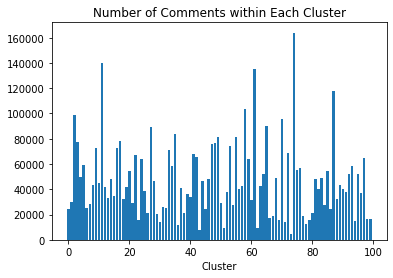

In [ ]:
plt.bar('clusters', 'count', data=clusters_counts2)
plt.xlabel('Cluster')
plt.title('Number of Comments within Each Cluster')
plt.show()

In [ ]:
df_importantwords = important_words(centers2, 10)
df_importantwords.head(15)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Cluster 43,yes,yesyes,yesyou,babey,erb,yeeeeessssss,yess,yesssssssssss,yea,yesss
Cluster 18,farkl,gelirmi,nceden,nceki,korktu,evcil,zellikle,bekliyorum,yerli,hamile
Cluster 60,hi,hello,hey,hiya,hii,hiii,hiiii,heyy,goodmorning,hiiiii
Cluster 98,3,3v,4,2,33,5,28,56,27,22
Cluster 84,nhe,phan,ngay,khoi,chua,nhap,toan,chung,uoc,nho
Cluster 3,ch,c,ngh,vcl,loz,trc,inh,cmnr,th,khinh
Cluster 64,eterno,recibir,yendo,espectacular,nuevamente,sobretodo,escuchan,aveces,conseguirlo,ayudarla
Cluster 32,lol,haha,lmao,hahaha,hahah,hahahahaha,hahahaha,lololol,ahahaha,rofl
Cluster 33,quiza,probablemente,vencerlo,ademas,pues,seguramente,ahora,sino,ahi,obviamente
Cluster 21,maravilloso,aqu,lex23,vuestro,aporte,xito,precioso,jejeje,siempre,felicitaciones


<br>Compared to cat/dog owners, the topics important to other users are less meaningful, probably because the comments from other users have much greater quantity and diversity than those from cat/dog owners, and thus are more difficult to cluster. On the other hand, it shows that the important topics of cat/dog owners are distinguishable from those of other users.<br><br>

## **6. Identify Creators with Cat/Dog Owners in The Audience**

I will use Spark SQL to find out creators with largest number of comments and creators with largest percentage of comments from cat/dog owners.<br><br>

In [ ]:
full_predictions.createOrReplaceTempView('fullpredictions')

In [ ]:
# creators with largest number of comments from cat/dog owners
num_comments = spark.sql('select creator_name, count(comment) as number_of_comments \
                          from fullpredictions where prediction=1 \
                          group by creator_name order by number_of_comments desc')
num_comments.show()

+--------------------+------------------+
|        creator_name|number_of_comments|
+--------------------+------------------+
|    Brave Wilderness|             67364|
|            The Dodo|             55293|
|  Taylor Nicole Dean|             41833|
|       Brian Barczyk|             40635|
|        Robin Seplut|             31279|
|Hope For Paws - O...|             24535|
|     Gohan The Husky|             19962|
|           Vet Ranch|             18698|
|    Cole & Marmalade|             14724|
|Gone to the Snow ...|             14468|
|     Viktor Larkhill|             12537|
|  Think Like A Horse|             12013|
|          stacyvlogs|             11610|
|       RaleighLink14|             10140|
|   Talking Kitty Cat|              9286|
|Zak Georges Dog T...|              9280|
|            ViralHog|              8353|
|        Mr. Max T.V.|              7720|
|            HammyLux|              7469|
|        Paws Channel|              6303|
+--------------------+------------

<br>After checking these creators on Youtube, I found that only a few of them are cat/dog owners; contents from other creators tend to be among more general and popular topics, such as animal rescuing, wild animals, and a few creators own pets other than cats/dogs. Of course, one thing common about these creators is that they are very popular on Youtube and over a half of them own more than 1 million subscribers. How about creators with largest percentage of comments from cat/dog owners?
<br><br>


In [ ]:
# creators with largest percentage of comments from cat/dog owners
per_comments = spark.sql('\
    with cte as \
    (select creator_name, \
     sum(case when prediction=1 then 1 else 0 end) over(partition by creator_name) as number_of_comments, \
     sum(case when True then 1 end) over(partition by creator_name) as total \
     from fullpredictions) \
    select creator_name, number_of_comments/total as percentage, number_of_comments \
    from cte \
    group by creator_name, percentage, number_of_comments \
    having number_of_comments>100 \
    order by percentage desc \
')
per_comments.show()

+--------------------+-------------------+------------------+
|        creator_name|         percentage|number_of_comments|
+--------------------+-------------------+------------------+
|           RatGirl44| 0.5194029850746269|               174|
|Zak Georges Dog T...|0.49700085689802914|              9280|
|       Brent Atwater| 0.4845679012345679|               314|
|         Larry Krohn|0.46370235934664245|               511|
|          wingsNpaws|0.44113756613756616|               667|
|      Floppycats.com|0.43568464730290457|               735|
|    Lennon The Bunny|0.42797319932998323|              4599|
|       Annas Animals| 0.4167852062588905|               293|
|        PetDogTricks| 0.4146341463414634|               153|
|       StormyRabbits|0.41243566560022255|              2965|
|         CRKtraining| 0.4077669902912621|               168|
|      Jackson Galaxy|0.38987883107626514|              1094|
|      Stonnie Dennis| 0.3878437047756874|               268|
|       

<br>As shown in the table above, the highest percentage of comments from cat/dog owners for all creators is 51.9%, and almost all of them are pet owners (cat/dog/rat/rabbit/etc.), and a few dog trainers specifically. It seems that my model would be useful to find out pet owners in general, but not so accurate in recognizing cat/dog owners. <br>Note that I excluded creators with few comments (less than 100) from analysis, since the percentage from those creators may not be quite meaningful.<br><br>

## **Summary**

**Motivation:**

Youtube comments contain lots of useful information to be extracted from, and it has become common practice to use NLP techniques to extract features from text. Word2Vec is a powerful NLP technique to transform text into a vector space such that words sharing common contexts are located close to one another. As a pet lover, it is certainly worthwhile to use Word2Vec model to analyze youtube comments in pet-related videos, getting the features, and further classifying users who are cat/dog owners.

**Steps:**


1.   Since the dataset is quite large (over 5 million comments), I loaded the data into Spark Dataframe, removed missing values in comment, and labeled cat/dog owners manually.

2.   After tokenizing comments into words, I trained a Word2Vec model to get the features for classification, and splitted the data into training and testing data.

3.   For the classification, I tried three different classifiers: logistic regression, random forest classifier, and gradient boosted trees (GBT) classifier. For every classifier I first trained and evaluated an initial model to get baseline performance, and then built a 5-fold cross-evaluation model to tune the model. The best model for this dataset is GBT classifier, with an Area under ROC score of 0.96 and accuracy of 0.90.

4.   I used the GBT classifier to classify the full dataset, getting an Area under ROC score of 0.97, and estimated that 12.3% of all users in this data are cat/dog owners.

5.   I used K-means Clustering to cluster the comments of predicted cat/dog owners and other users, respectively. Then I found the most important words for each cluster, using the findSynonym method of the Word2VecModel to compute the cosine similarity between words and cluster centroids.

6.   I used Spark SQL to find creators with largest number of comments from cat/dog owners, as well as creators with largest statistically meaningful percentage of comments from cat/dog owners.



**Conclusion:**

In this notebook I have used Spark to analyse a dataset of youtube user comments for pet-related videos, and used Word2Vec, GBT classifier, and K-means Clustering to classify cat/dog owners and find topics important to them. The result shows that 12.3% users are cat/dog owners for pet-related videos, whose topics in comments are much more related to pets compared to other users, and up to 50% comments are from cat/dog owners for all creators of these videos. Future work could improve the model accuracy in recognizing cat/dog owners among pet owners in general, utilize these models to make personalized recommendations to pet owners, and improve topic modeling on non-pet owners to make fine-grained distinctions.